<a href="https://colab.research.google.com/github/mayhd3/NSF-REU-2021/blob/main/AMIvisualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

if not os.path.exists('SM-30.csv'):
  !gdown --id 1UnP8x_WQ-Aroq8Rz4C1NUSEG9Iul1y7r

sm30 = pd.read_csv('SM-30.csv', header=None)
print(sm30)

        0         1          2   ...          48          49          50
0        1  20160101     Friday  ...   51.175717  143.252283  137.462967
1        1  20160102   Saturday  ...   69.247467   34.006950   13.018783
2        1  20160103     Sunday  ...   87.413983   34.309583    8.045783
3        1  20160104     Monday  ...   57.762917   59.193917   84.350667
4        1  20160105    Tuesday  ...   99.809000   37.494800   62.593817
...    ...       ...        ...  ...         ...         ...         ...
39781  114  20161210   Saturday  ...  103.174867  105.520250   99.261717
39782  114  20161211     Sunday  ...   78.534017   55.942400   61.001317
39783  114  20161212     Monday  ...   94.071350   39.962617   71.267533
39784  114  20161213    Tuesday  ...  114.110617   71.144167   66.459417
39785  114  20161214  Wednesday  ...   80.857933   60.401817   68.659183

[39786 rows x 51 columns]


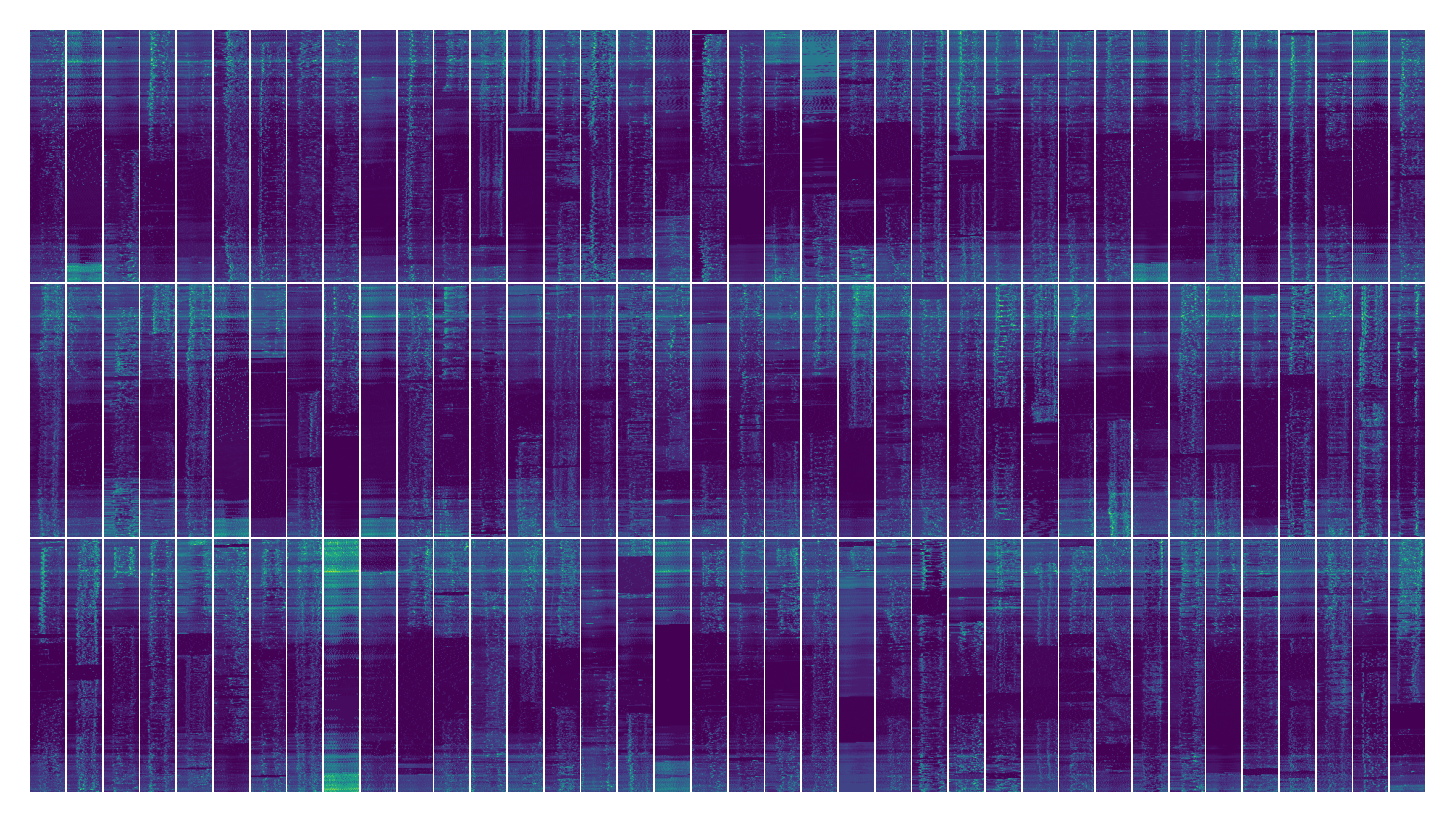

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

reals = np.split(
    sm30.iloc[:,3:].to_numpy(),
    sm30[0].diff()[1:].to_numpy().nonzero()[0] + 1
)

def heatmap(data):
  ig = ImageGrid(plt.gcf(), 111, nrows_ncols=(3, 38), axes_pad=2/300, direction='column')

  for ax,im in zip(ig,data):
    ax.set_axis_off()
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im)

plt.figure(dpi=300)
heatmap(reals)

In [3]:
import ipywidgets as ipw
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.colors as mcolors

out1 = ipw.Output()

def plot_with_acf(out, data, index, starts=None):
  colors = list(mcolors.TABLEAU_COLORS.values())
  color = colors[index%len(colors)]

  if 0 <= index < len(data):
    flat = data[index].flatten()

    out.clear_output()
    with out:
      fig1 = plt.figure(dpi=100)
      plt.title("Meter " + str(index))
      plt.plot(flat, c=color)
      if starts is not None:
        plt.axvline(starts[index] * len(data[index][0]), c='r')

      fig2 = plt.figure(dpi=100)
      plot_acf(flat, ax=plt.gca(), lags=np.arange(len(flat))[::500], c=color)
      if starts is not None:
        plt.axvline(starts[index] * len(data[index][0]), c='r')

      plt.show()
      return fig1, fig2

it1 = ipw.IntText(
  value=0,
  description='Meter to plot:',
  style={'description_width': 'initial'}
)

it1.observe(lambda event: plot_with_acf(out1, reals, event['new']), names='value')
plot_with_acf(out1, reals, it1.value)

display(it1, out1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


IntText(value=0, description='Meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [4]:
out3 = ipw.Output()

for index in range(len(reals)):
  if not os.path.exists('acf/'):
    os.mkdir('acf/')
  path1, path2 = 'acf/'+str(index)+'.png', 'acf/'+str(index)+'_acf.png'
  exists1, exists2 = os.path.exists(path1), os.path.exists(path2)
  if not exists1 or not exists2:
    fig1, fig2 = plot_with_acf(out3, reals, index)
    if not exists1:
      fig1.savefig(path1)
    if not exists2:
      fig2.savefig(path2)

if not os.path.exists('acf.zip'):
  !zip -r acf.zip acf/

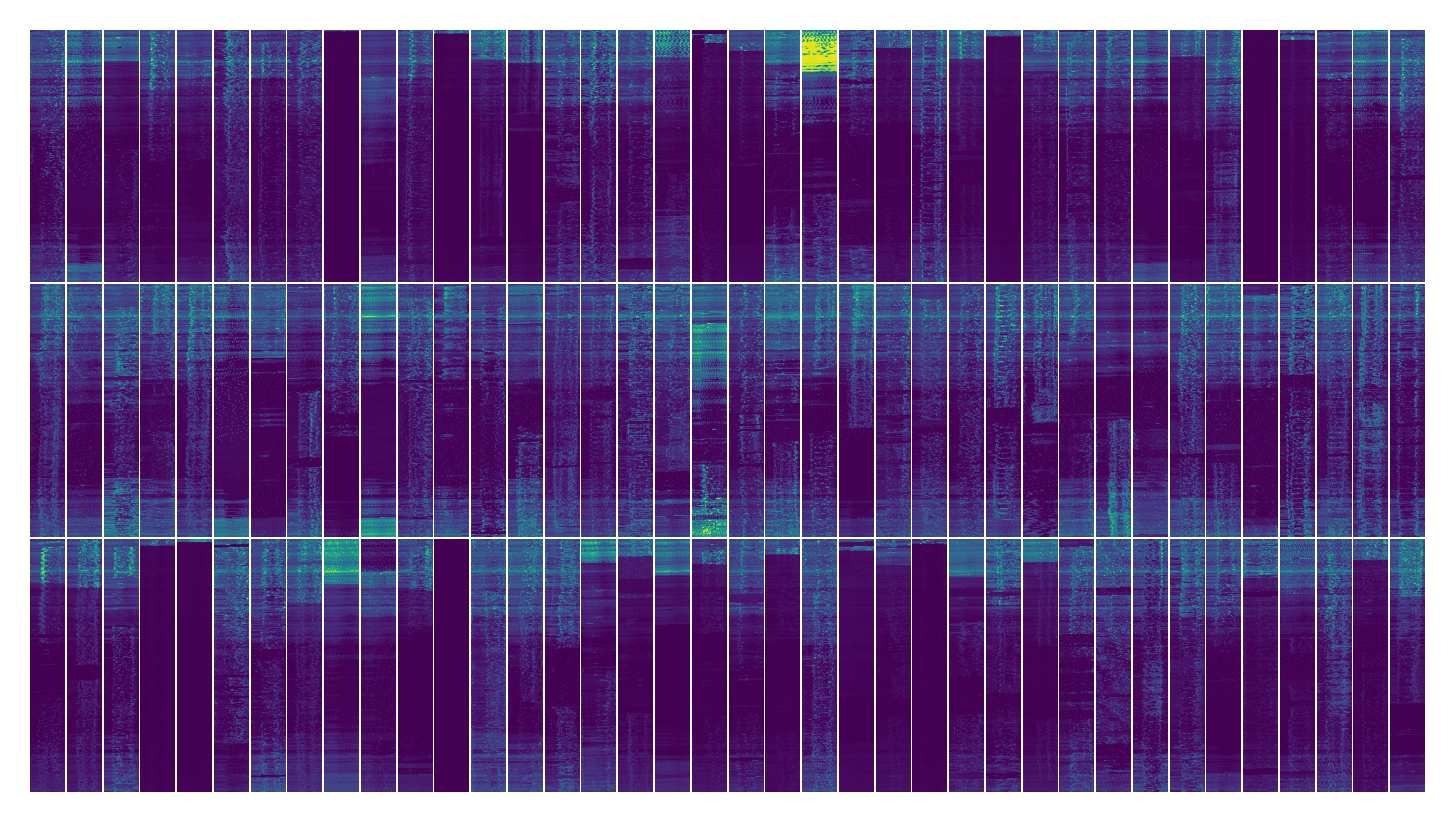

In [5]:
from copy import deepcopy

# simulate energy theft by scaling samples down, clipping them to a max, or both
fakes = deepcopy(reals)

# each sample will have a different starting date
linear = np.linspace(0,1,num=len(fakes),endpoint=False)
np.random.shuffle(linear)
starts = np.multiply(linear, [len(fake)/2 for fake in fakes]).astype(int)

for i in range(len(fakes)):
  # theft starts at most half way through the year
  start = starts[i]

  if (i%3) != 1:
    for j in range(start,len(fakes[i])):
      fakes[i][j] *= linear[i]

  if (i%3) != 0:
    # clip max to somewhere between the first and third quartile
    min, max = np.amin(fakes[i][start:]), np.amax(fakes[i][start:])
    lerp = linear[(i+1)%len(linear)]
    clip = (max+min)*.5 + (max-min)*.25*(lerp-.5)
    for j in range(start,len(fakes[i])):
      fakes[i][j] = np.clip(fakes[i][j],0,clip) 

plt.figure(dpi=300)
heatmap(fakes)

In [6]:
out2 = ipw.Output()

it2 = ipw.IntText(
  value=0,
  description='Fake meter to plot:',
  style={'description_width': 'initial'}
)

it2.observe(
  lambda event: plot_with_acf(out2, fakes, event['new'], starts),
  names='value'
)

plot_with_acf(out2, fakes, it2.value, starts)

display(it2, out2)

IntText(value=0, description='Fake meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [7]:
# sanity check, fake data shows lower power consumption than the real data
assert(np.less_equal(fakes,reals).all())

# make a similar dataframe with the shuffled fake data
shuffle = np.random.permutation(len(fakes))
sm30f = pd.DataFrame(np.column_stack((
  sm30[range(3)],
  np.concatenate(np.take(fakes, shuffle, axis=0))
)))

# mask the interval that covers where our fake readings begin
sm30f = sm30f.shift(axis='columns')
for i in shuffle:
  index = sm30f[sm30f[1] == i+1].index
  start = index[0] + starts[i]
  sm30f[0][range(index[0], start)] = 0
  sm30f[0][range(start, index[-1]+1)] = 1

# label which kind of fake data is in each row
sm30f = sm30f.shift(axis='columns')
sm30f[0] = np.take(shuffle, sm30f[2] - 1) % 3 + 1
sm30f[2] += len(fakes)

# combine both dataframes to make our training and testing datasets
full = pd.concat((
  sm30.shift(axis='columns', periods=2, fill_value=0),
  sm30f
)).reset_index(drop=True)

print(full)
if not os.path.exists('full.zip'):
  full.to_csv('full.zip', index=False, compression=dict(method='zip'))

       0  1    2         3   ...       47       48       49       50
0       0  0    1  20160101  ...  41.5937  37.2213  38.4995  51.1757
1       0  0    1  20160102  ...  77.3123  59.3962  58.4204  69.2475
2       0  0    1  20160103  ...  74.5085  62.4546   47.916   87.414
3       0  0    1  20160104  ...  57.2456  59.1451  72.3213  57.7629
4       0  0    1  20160105  ...  55.3683  66.2452  55.6019   99.809
...    .. ..  ...       ...  ...      ...      ...      ...      ...
79567   3  1  228  20161210  ...  76.4093  87.3277  47.5362  52.5155
79568   3  1  228  20161211  ...  74.9668  30.9552  31.6514  75.6254
79569   3  1  228  20161212  ...  51.4013  81.0913  47.1438  34.5288
79570   3  1  228  20161213  ...  53.6622  18.4014  38.9963  82.2625
79571   3  1  228  20161214  ...  96.9787  51.5213  42.2127  73.8691

[79572 rows x 51 columns]
